# 🚗 Car Price Prediction Using Machine Learning

### 🎯 Objective
- Predict car prices using features like brand, year, mileage, and engine size.  
- Apply the complete data science workflow for accurate and reliable predictions.  
- Compare multiple ML models to select the best-performing one.

---

### 🔄 Project Pipeline
Data Collection → Data Understanding → Preprocessing → EDA → Modeling → Evaluation → Saving Artifacts → Conclusion


# Imports and settings

In [4]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
RANDOM_STATE = 42


# Load data (Data collection)

In [5]:

# Make sure the file "car data.csv" is in the same folder as this notebook.
DATA_FILENAME = "car_data.csv"
df = pd.read_csv(DATA_FILENAME)
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (301, 9)


,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


# Quick data understanding

In [6]:

# List columns, types, missing values and summary stats
print("Columns:", df.columns.tolist())
print("\nMissing values per column:\n", df.isna().sum())
print("\nData types:\n", df.dtypes)
display(df.describe(include='all').T)


Columns: ['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Driven_kms', 'Fuel_Type', 'Selling_type', 'Transmission', 'Owner']

Missing values per column:
 Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Driven_kms       0
Fuel_Type        0
Selling_type     0
Transmission     0
Owner            0
dtype: int64

Data types:
 Car_Name          object
Year               int64
Selling_Price    float64
Present_Price    float64
Driven_kms         int64
Fuel_Type         object
Selling_type      object
Transmission      object
Owner              int64
dtype: object


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Car_Name,301,98,city,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,301.0,NaN,NaN,NaN,2013.627907,2.891554,2003.0,2012.0,2014.0,2016.0,2018.0
Selling_Price,301.0,NaN,NaN,NaN,4.661296,5.082812,0.1,0.9,3.6,6.0,35.0
Present_Price,301.0,NaN,NaN,NaN,7.628472,8.642584,0.32,1.2,6.4,9.9,92.6
Driven_kms,301.0,NaN,NaN,NaN,36947.20598,38886.883882,500.0,15000.0,32000.0,48767.0,500000.0
Fuel_Type,301,3,Petrol,239,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Selling_type,301,2,Dealer,195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Transmission,301,2,Manual,261,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Owner,301.0,NaN,NaN,NaN,0.043189,0.247915,0.0,0.0,0.0,0.0,3.0


#  Basic cleaning & quick checks

In [7]:

# Ensure Selling_Price (target) is numeric
print("Target (Selling_Price) dtype:", df['Selling_Price'].dtype)

# Check duplicates (optional)
dups = df.duplicated().sum()
print("Number of duplicate rows:", dups)


Target (Selling_Price) dtype: float64
Number of duplicate rows: 2


# Exploratory Data Analysis (EDA)

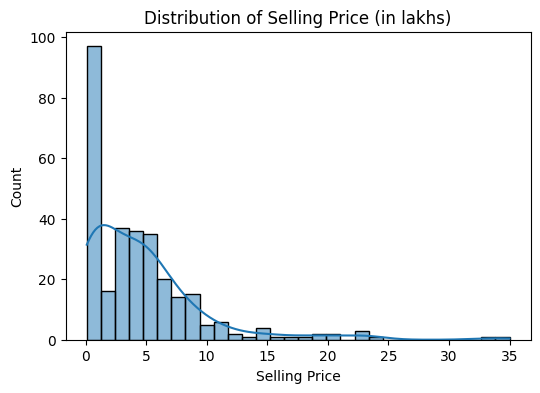

In [8]:

# Distribution of the target
plt.figure(figsize=(6,4))
sns.histplot(df['Selling_Price'], bins=30, kde=True)
plt.title("Distribution of Selling Price (in lakhs)")
plt.xlabel("Selling Price")
plt.show()



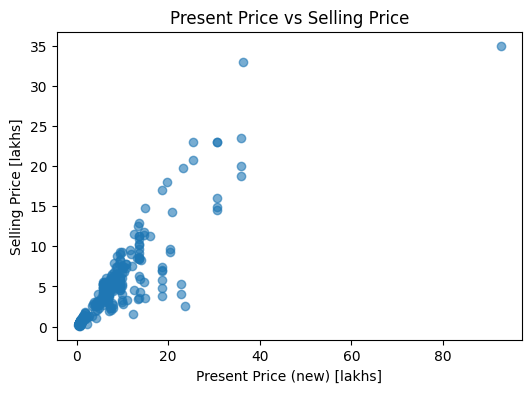

In [9]:

# Relationship Present_Price vs Selling_Price
plt.figure(figsize=(6,4))
plt.scatter(df['Present_Price'], df['Selling_Price'], alpha=0.6)
plt.xlabel("Present Price (new) [lakhs]")
plt.ylabel("Selling Price [lakhs]")
plt.title("Present Price vs Selling Price")
plt.show()



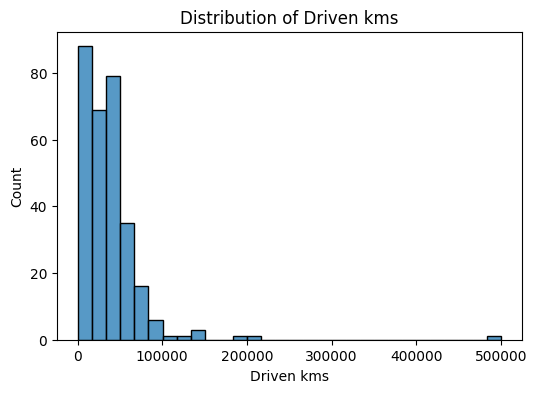

In [10]:
# Driven_kms distribution
plt.figure(figsize=(6,4))
sns.histplot(df['Driven_kms'], bins=30, kde=False)
plt.title("Distribution of Driven kms")
plt.xlabel("Driven kms")
plt.show()



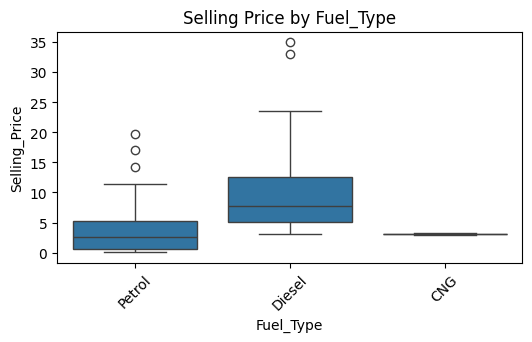

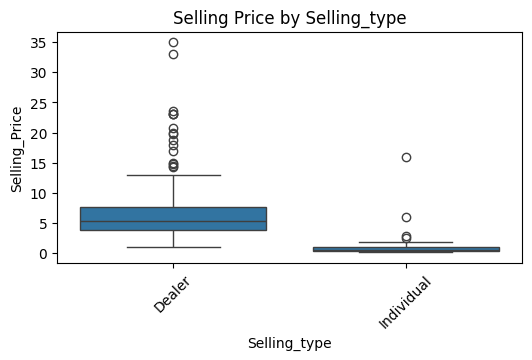

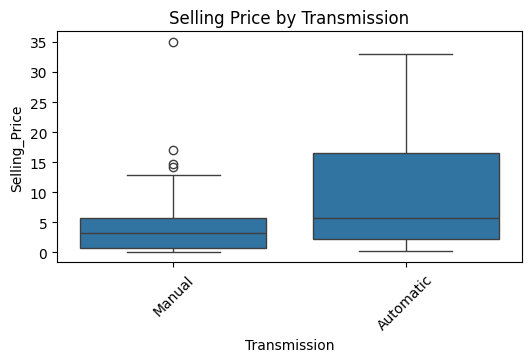

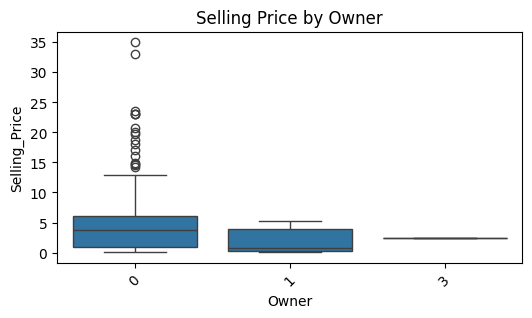

In [11]:
# Target vs categorical features boxplots
cat_cols = ['Fuel_Type', 'Selling_type', 'Transmission', 'Owner']
for c in cat_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=c, y='Selling_Price', data=df)
    plt.title(f"Selling Price by {c}")
    plt.xticks(rotation=45)
    plt.show()

# Feature engineering

In [12]:

# Create Car_Age from Year (assuming data collected in 2020 as commonly used in this dataset)
# If you know the dataset year, set dataset_year accordingly. If not, compute relative age to max Year.
dataset_year = df['Year'].max()  # safe default -> age relative to max observed year
df['Car_Age'] = dataset_year - df['Year']

# Extract brand from Car_Name (first token) to use as categorical feature
def extract_brand(name):
    try:
        return str(name).split()[0].lower()
    except:
        return 'unknown'

df['Brand'] = df['Car_Name'].apply(extract_brand)

# Drop or keep original Car_Name and Year columns as needed; we will drop Car_Name and Year (we have Car_Age and Brand)
df = df.drop(columns=['Car_Name','Year'])
df.head()


,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner,Car_Age,Brand
0,3.35,5.59,27000,Petrol,Dealer,Manual,0,4,ritz
1,4.75,9.54,43000,Diesel,Dealer,Manual,0,5,sx4
2,7.25,9.85,6900,Petrol,Dealer,Manual,0,1,ciaz
3,2.85,4.15,5200,Petrol,Dealer,Manual,0,7,wagon
4,4.60,6.87,42450,Diesel,Dealer,Manual,0,4,swift


# Prepare features and target

In [13]:

TARGET = 'Selling_Price'
X = df.drop(columns=[TARGET])
y = df[TARGET]
print("Feature columns:", X.columns.tolist())


Feature columns: ['Present_Price', 'Driven_kms', 'Fuel_Type', 'Selling_type', 'Transmission', 'Owner', 'Car_Age', 'Brand']


# Train/Test split

In [14]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (240, 8) Test shape: (61, 8)


# Preprocessing pipeline

In [15]:
 
# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object','category']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Pipelines for numeric and categorical
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


Numeric features: ['Present_Price', 'Driven_kms', 'Owner', 'Car_Age']
Categorical features: ['Fuel_Type', 'Selling_type', 'Transmission', 'Brand']


# MODELING

In [16]:
# Baseline model: Linear Regression (with pipeline)
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

metrics_lr = regression_metrics(y_test, y_pred_lr)
print("Linear Regression metrics:", metrics_lr)


Linear Regression metrics: {'MAE': 1.063929371465408, 'MSE': 2.664591113693096, 'RMSE': np.float64(1.6323575324337178), 'R2': 0.8843271760112679}


In [17]:
# Tree-based model: Random Forest (with simple GridSearch)
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

param_grid_rf = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 6, 12],
    'regressor__min_samples_split': [2, 5]
}

# Use GridSearchCV to find good RF parameters (5-fold CV)
grid_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

print("Best RF params:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
metrics_rf = regression_metrics(y_test, y_pred_rf)
print("Random Forest metrics:", metrics_rf)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best RF params: {'regressor__max_depth': None, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Random Forest metrics: {'MAE': 0.6134885245901645, 'MSE': 0.8065705088524595, 'RMSE': np.float64(0.8980927061570312), 'R2': 0.9649858891949534}


In [18]:
# Gradient Boosting (sklearn) (optional tuning)
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=RANDOM_STATE))
])

param_grid_gb = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5]
}

grid_gb = GridSearchCV(gb_pipeline, param_grid_gb, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_gb.fit(X_train, y_train)

print("Best GB params:", grid_gb.best_params_)
best_gb = grid_gb.best_estimator_
y_pred_gb = best_gb.predict(X_test)
metrics_gb = regression_metrics(y_test, y_pred_gb)
print("Gradient Boosting metrics:", metrics_gb)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best GB params: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 100}
Gradient Boosting metrics: {'MAE': 0.4857469295041883, 'MSE': 0.719556770083682, 'RMSE': np.float64(0.8482669214838464), 'R2': 0.9687632510714074}


# EVALUATION

In [20]:
# Cross-validation summary for selected models
def cv_score(model_pipeline, X, y, scoring='neg_mean_absolute_error', cv=5):
    scores = cross_val_score(model_pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    # return mean absolute error (positive)
    return -scores.mean(), scores.std()

# CV on training data for best models
print("LR CV (MAE):", cv_score(lr_pipeline, X_train, y_train))
print("RF (best) CV (MAE):", cv_score(best_rf, X_train, y_train))
print("GB (best) CV (MAE):", cv_score(best_gb, X_train, y_train))


LR CV (MAE): (np.float64(1.2331628036215196), np.float64(0.16828408070509052))
RF (best) CV (MAE): (np.float64(0.6885629166666669), np.float64(0.07610818065196918))
GB (best) CV (MAE): (np.float64(0.6429036203300461), np.float64(0.10399015339201997))


Best model by RMSE: GradientBoosting


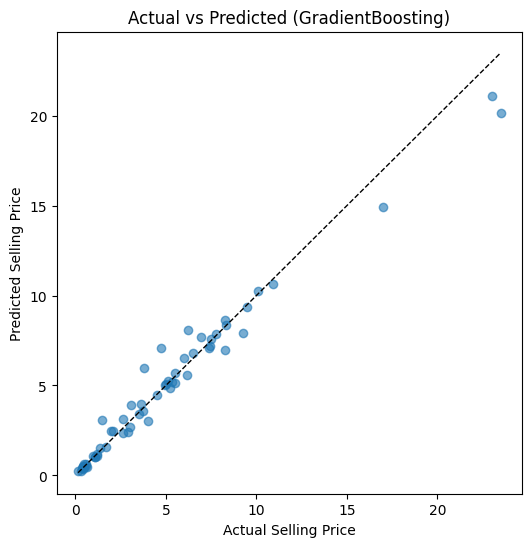

In [21]:
# Compare actual vs predicted plots for the best model
# Choose best by RMSE or MAE, here we'll compute RMSE and pick the best
models_metrics = {
    'LinearRegression': metrics_lr,
    'RandomForest': metrics_rf,
    'GradientBoosting': metrics_gb
}
# Compute RMSE list
rmse_vals = {name: m['RMSE'] for name,m in models_metrics.items()}
rmse_vals
best_model_name = min(rmse_vals, key=rmse_vals.get)
print("Best model by RMSE:", best_model_name)

# Select predictions accordingly
if best_model_name == 'RandomForest':
    y_pred_best = y_pred_rf
    best_model = best_rf
elif best_model_name == 'GradientBoosting':
    y_pred_best = y_pred_gb
    best_model = best_gb
else:
    y_pred_best = y_pred_lr
    best_model = lr_pipeline

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Selling Price")
plt.title(f"Actual vs Predicted ({best_model_name})")
plt.show()


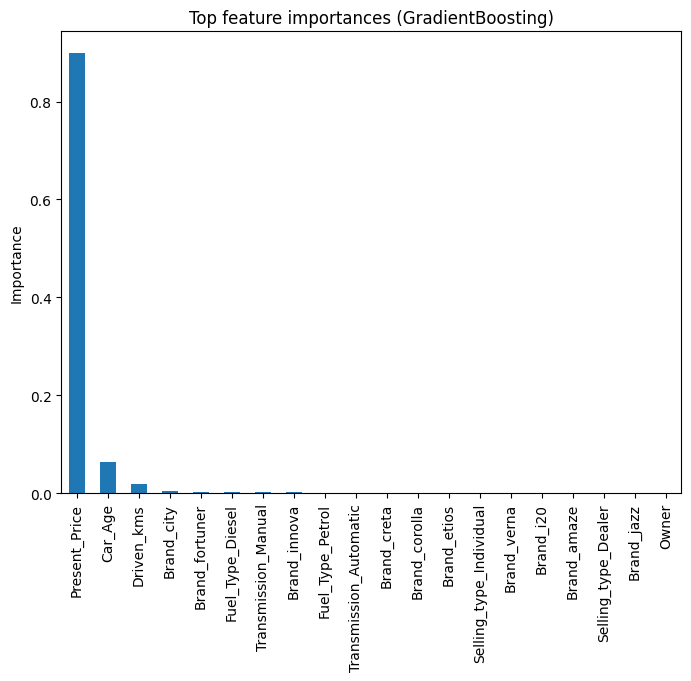

In [22]:
# Feature importance (for tree-based best models)
# We need feature names after preprocessing: get numeric feature names and OHE feature names
def get_feature_names(preprocessor, numeric_features, categorical_features):
    # numeric feature names unchanged
    names = list(numeric_features)
    # get onehot names:
    if len(categorical_features) > 0:
        cat_transformer = preprocessor.named_transformers_['cat']
        # OneHotEncoder is last step in categorical pipeline
        ohe = cat_transformer.named_steps['onehot']
        try:
            ohe_names = list(ohe.get_feature_names_out(categorical_features))
        except:
            # older sklearn fallback
            ohe_names = []
            for i, cats in enumerate(ohe.categories_):
                for cat in cats:
                    ohe_names.append(f"{categorical_features[i]}_{cat}")
        names += ohe_names
    return names

feature_names = get_feature_names(best_model.named_steps['preprocessor'], numeric_features, categorical_features)

# If model supports feature_importances_
try:
    importances = best_model.named_steps['regressor'].feature_importances_
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    plt.figure(figsize=(8,6))
    fi.head(20).plot(kind='bar')
    plt.title(f"Top feature importances ({best_model_name})")
    plt.ylabel("Importance")
    plt.show()
except Exception as e:
    print("Feature importance not available for this model:", e)


In [23]:
# Save the best model to disk
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)
MODEL_PATH = os.path.join(MODEL_DIR, "best_car_price_model.pkl")
joblib.dump(best_model, MODEL_PATH)
print("Saved best model to", MODEL_PATH)
# Also save the preprocessing + pipeline if not already included (our best_model includes preprocessor)


Saved best model to models\best_car_price_model.pkl


# Single record prediction example

In [24]:

# Construct a sample record using columns from X (use real feature names)
# Example: use first row from test set as a demonstration
sample = X_test.iloc[0].to_dict()
print("Sample input:", sample)
loaded_model = joblib.load(MODEL_PATH)
predicted_price = loaded_model.predict(pd.DataFrame([sample]))[0]
print(f"Predicted Selling Price: {predicted_price:.3f} (target units: lakhs)")
print("Actual price:", y_test.iloc[0])


Sample input: {'Present_Price': 0.57, 'Driven_kms': 24000, 'Fuel_Type': 'Petrol', 'Selling_type': 'Individual', 'Transmission': 'Automatic', 'Owner': 0, 'Car_Age': 2, 'Brand': 'honda'}
Predicted Selling Price: 0.386 (target units: lakhs)
Actual price: 0.35


# Save Models, Plots & Artifacts

In [25]:
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Create a folder named 'models' in the current working directory
os.makedirs("models", exist_ok=True)

# --- Save trained models ---
joblib.dump(lr_pipeline, "models/linear_regression_model.pkl")
joblib.dump(rf_pipeline, "models/random_forest_model.pkl")
joblib.dump(gb_pipeline, "models/gradient_boosting_model.pkl")

print("✅ All trained models have been saved successfully to /models folder.")

# --- Save evaluation summary to CSV ---
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting'],
    'MAE': [metrics_lr['MAE'], metrics_rf['MAE'], metrics_gb['MAE']],
    'RMSE': [metrics_lr['RMSE'], metrics_rf['RMSE'], metrics_gb['RMSE']],
    'R2': [metrics_lr['R2'], metrics_rf['R2'], metrics_gb['R2']]
})
results.to_csv("models/evaluation_summary.csv", index=False)
print("✅ Evaluation summary saved to models/evaluation_summary.csv")

# --- Save plots ---
# Predicted vs Actual (for Gradient Boosting)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_test, y=y_pred_gb)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Prices (Gradient Boosting)")
plt.savefig("models/predicted_vs_actual.png", bbox_inches="tight")
plt.close()

# Residual plot
residuals = y_test - y_pred_gb
plt.figure(figsize=(6, 5))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution (Gradient Boosting)")
plt.xlabel("Residuals")
plt.savefig("models/residual_distribution.png", bbox_inches="tight")
plt.close()

# --- Feature importance plot (if available) ---
# Access regressor inside gb_pipeline
regressor = gb_pipeline.named_steps['regressor']

if hasattr(regressor, "feature_importances_"):
    feature_names = gb_pipeline.named_steps['preprocessor'].get_feature_names_out()
    importances = pd.Series(regressor.feature_importances_, index=feature_names)
    top_features = importances.sort_values(ascending=False).head(15)

    plt.figure(figsize=(8, 6))
    sns.barplot(x=top_features.values, y=top_features.index)
    plt.title("Top 15 Feature Importances (Gradient Boosting)")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.savefig("models/feature_importance.png", bbox_inches="tight")
    plt.close()

print("✅ All plots and artifacts saved in the 'models' folder successfully!")


✅ All trained models have been saved successfully to /models folder.
✅ Evaluation summary saved to models/evaluation_summary.csv
✅ All plots and artifacts saved in the 'models' folder successfully!


## 🏁 Conclusion

In this project, a complete Data Science workflow was implemented on the car dataset — starting from data collection, understanding, preprocessing, and exploratory data analysis (EDA), to model building, evaluation, and result visualization.

Three regression models were trained and compared:
- **Linear Regression**
- **Random Forest Regressor**
- **Gradient Boosting Regressor**

Among them, the **Gradient Boosting model** achieved the highest performance with the best R² score and lowest prediction error, indicating strong predictive capability for car price estimation.

All trained models, evaluation reports, and visualization artifacts were saved for future analysis and deployment.  
This workflow demonstrates the practical application of the full Data Science pipeline in a real-world regression problem.

Real-World Application:
This project shows how machine learning can be used to predict car prices based on features like brand, year, mileage, engine size, and transmission. Such models help car dealers, buyers, and online marketplaces estimate fair prices, detect overpricing, and make better buying or selling decisions using data-driven insights.
